In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline 
from brokenaxes import brokenaxes
%config InlineBackend.figure_format = 'svg' 
from IPython.display import Latex

In [45]:
data = pd.read_csv('M-H_curve.csv',sep=',')
print(data)

     Magnetic Field (Oe)  Moment(emu)  M (emu/g)
0               -19617.0     -1.28668  -31.52082
1               -19265.4     -1.28564  -31.49535
2               -18847.5     -1.28419  -31.45982
3               -18435.4     -1.28255  -31.41965
4               -18029.4     -1.28072  -31.37482
..                   ...          ...        ...
508             -17682.4     -1.27822  -31.31357
509             -18078.0     -1.28024  -31.36306
510             -18470.8     -1.28207  -31.40789
511             -18862.2     -1.28371  -31.44806
512             -19245.2     -1.28515  -31.48334

[513 rows x 3 columns]


In [46]:
Magnetic_Field = data['Magnetic Field (Oe)']
Magnetic_Field

0     -19617.0
1     -19265.4
2     -18847.5
3     -18435.4
4     -18029.4
        ...   
508   -17682.4
509   -18078.0
510   -18470.8
511   -18862.2
512   -19245.2
Name: Magnetic Field (Oe), Length: 513, dtype: float64

In [47]:
Moment = data['M (emu/g)']
Moment

0     -31.52082
1     -31.49535
2     -31.45982
3     -31.41965
4     -31.37482
         ...   
508   -31.31357
509   -31.36306
510   -31.40789
511   -31.44806
512   -31.48334
Name: M (emu/g), Length: 513, dtype: float64

# Langevin fitting equation

[Ref: Langevin fitting in ferrofluids](https://ieeexplore.ieee.org/abstract/document/1059918) 

[Ref: satuation magnetization of bulk magnetite](https://pubs.rsc.org/en/content/articlelanding/2012/CS/c2cs15337h)   
$ 98\  A m^2 kg^{−1} $ in SI unit    
$ 98\  emu g^{-1} $ in cgs unit

* Langevin function:
$$
L = \coth b - 1/b
$$
* coth funciton:
$$
L1 = \coth b
$$
* fitting process
$$
I = {I_S}\int_0^\infty  {Lf(y)dy}
$$
$$
I = {I_S}\int_0^\infty  {(\coth b - 1/b)f(y)dy}
$$
$$
I = {I_S}\int_0^\infty  {\coth b{\rm{ }}f(y){\rm{dy}} - \int_0^\infty  {1/b{\rm{ }}f(y)dy} }
$$
$$
{I_S} = \varepsilon I_S'
$$
$$
I = \varepsilon I_S'[\int_0^\infty  {\coth b{\rm{ }}f(y){\rm{dy}} - \int_0^\infty  {1/b{\rm{ }}f(y)dy} } ]
$$
* lognormal distribution function:
$$
f(y) = \frac{1}{{y\sigma \sqrt {2\pi } }}\exp ( - {(\ln (y))^2}/2{\sigma ^2})
$$
    * simplification:
$$
\int_0^\infty  {{y^n}f(y)dy = } \int_0^\infty  {{y^n}\frac{{\exp ( - {{(\ln (y))}^2}/2{\sigma ^2})dy}}{{y\sigma \sqrt {2\pi } }}} 
$$
$$
z = (\ln (y))/\sigma  - n\sigma 
$$
$$
\int_0^\infty  {{y^n}f(y)dy = } \exp ({n^2}{\sigma ^2}/2)\int_{ - \infty }^\infty  {\frac{{\exp ( - {z^2}/2)dz}}{{\sqrt {2\pi } }}}  = \exp ({n^2}{\sigma ^2}/2)
$$
$$
\int_{ - \infty }^\infty  {\exp ( - {z^2}/2)/\sqrt {2\pi }  = 1} 
$$
* simplification and calculation of Langevin fitting equation:
$$
M_S=4\pi I_S
$$
$$
M_S'=4\pi I_S'
$$
$$
a = M_S'\pi D_V^3/(6kT)
$$
$$
b = M_S'H\pi D_V^3{y^3}/(6kT)
$$
$$
\int_0^\infty  {1/b{\rm{ }}f(y)dy}  = \frac{{6kT}}{{M_S'H\pi D_V^3}}\int_0^\infty  {{y^{ - 3}}f(y)dy}
$$
$$
\int_0^\infty  {1/b{\rm{ }}f(y)dy}  = \frac{{6kT}}{{M_S'H\pi D_V^3}}\exp ({n^2}{\sigma ^2}/2),n =  - 3
$$
$$
M = \varepsilon M_S'[\int_0^\infty  {\coth b{\rm{ }}f(y){\rm{dy}} - \int_0^\infty  {1/b{\rm{ }}f(y)dy} } ]
$$
$$
M = \varepsilon M_S'[v - \frac{{\exp ({n^2}{\sigma ^2}/2)}}{aH}]
$$

In [48]:
k = 1.380649e-23 # unit: J/K
T = 298.15 # unit: K
sigma = 0.42 # standard deviation of y
d = 5.8e-9 # unit: m
Ms_prime = 98 # unit: emu/g; satuation magnetization of bulk magnetite

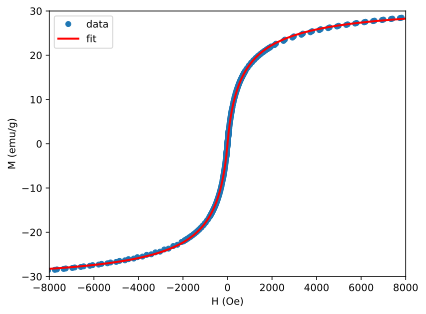

In [49]:
Moment_fitting = []
epsilon = Moment.max() / Ms_prime  # volume fraction of magnetite nanoparticles
a = Ms_prime*np.pi*d**3/(6*k*T)

for H in Magnetic_Field: 
    
    # integral function
    def func(y):
        b = a*H*y**3
        # coth() function
        L1 = 1/np.tanh(b)
        # lognormal distribution function
        f_y = 1/(y*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(y))**2/2/sigma**2)
        return L1*f_y
    # quad function could return value(v) and error(err). 
    v,err = integrate.quad(func, 0, np.inf)
    # adding Moment value of the langevin fitting to Moment_fitting list.
    Moment_fitting.append(epsilon*Ms_prime*(v-1/(a*H)*np.exp(4.5*sigma**2)))

plt.plot(Magnetic_Field,Moment, '.', markersize=10,label='data')
plt.plot(Magnetic_Field,Moment_fitting,'r-',linewidth=2,label='fit')
plt.ylim(-30,30)
plt.xlim((-8000,8000))
plt.xlabel('H (Oe)')
plt.ylabel('M (emu/g)')
plt.legend()
plt.savefig("langevin fitting curve.png",dpi=300) 
plt.show()

In [50]:
epsilon

0.32106357142857145

In [51]:
result=np.hstack((np.array(Magnetic_Field)[:,np.newaxis],np.array(Moment_fitting)[:,np.newaxis]))

In [52]:
result=pd.DataFrame(result,columns=['Magnetic_Field','Moment_fitting'])
result

,Magnetic_Field,Moment_fitting
0,-19617.0,-30.052669
1,-19265.4,-30.028239
2,-18847.5,-29.998090
3,-18435.4,-29.967106
4,-18029.4,-29.935286
...,...,...
508,-17682.4,-29.907008
509,-18078.0,-29.939165
510,-18470.8,-29.969819
511,-18862.2,-29.999172


In [53]:
result.to_csv('Langevin_fitting_data.csv') # export fitting data